In [1]:
%matplotlib inline

import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use("springer_1c")
plt.rcParams['text.usetex'] = True

from uncertainties import unumpy

import rampy as rp

import structupy

In [33]:
def polycorners(ncorners=3):
    '''
    Return 2D cartesian coordinates of a regular convex polygon of a specified
    number of corners.
    Args:
        ncorners (int, optional) number of corners for the polygon (default 3).
    Returns:
        (ncorners, 2) np.ndarray of cartesian coordinates of the polygon.
    '''

    center = np.array([0.5, 0.5])
    points = []

    for i in range(ncorners):
        angle = (float(i) / ncorners) * (np.pi * 2) + (np.pi / 2)
        x = center[0] + np.cos(angle) * 0.5
        y = center[1] + np.sin(angle) * 0.5
        points.append(np.array([x, y]))

    return np.array(points)

def bary2cart(bary, corners):
    '''
    Convert barycentric coordinates to cartesian coordinates given the
    cartesian coordinates of the corners.
    Args:
        bary (np.ndarray): barycentric coordinates to convert. If this matrix
            has multiple rows, each row is interpreted as an individual
            coordinate to convert.
        corners (np.ndarray): cartesian coordinates of the corners.
    Returns:
        2-column np.ndarray of cartesian coordinates for each barycentric
        coordinate provided.
    '''

    cart = None

    if len(bary.shape) > 1 and bary.shape[1] > 1:
        cart = np.array([np.sum(b / np.sum(b) * corners.T, axis=1) for b in bary])
    else:
        cart = np.sum(bary / np.sum(bary) * corners.T, axis=1)

    return cart


In [421]:
CA_dataset = pd.read_excel("../data/CaO_.xlsx")
CA_dataset = CA_dataset.dropna(subset=["Tg_K"])
CA_dataset = structupy.chimie_control(CA_dataset)
IFS_Ca = structupy.ifs(CA_dataset)

print(CA_dataset.columns)


# For entropy map
cart_ = bary2cart(CA_dataset.loc[:,["cao","sio2","al2o3"]].values, corners=np.array([[0,0],[1,1],[2,0]]))
arrow_coords = bary2cart(np.array([[50.,50.,0.],[10.,50.,40.]]), corners=np.array([[0,0],[1,1],[2,0]]))

# For Raman spectra...
num_x_points = 1300
x = np.zeros((num_x_points,len(CA_dataset)))
spectra = np.zeros((len(x),len(CA_dataset)))

x_array = np.arange(55,1200,1.0)
spectra_array = np.zeros((len(x_array),len(CA_dataset)))

for idx,name in enumerate(CA_dataset['spectre']):
    #print(name)
    sp = np.genfromtxt("../data/raman/"+name)
    sp = rp.flipsp(sp)
    x[:,idx] = np.linspace(sp[0,0],sp[-1,0],num_x_points)
    spectra[:,idx] = rp.resample(sp[:,0],sp[:,1],x[:,idx])
    
    spectra[:,idx] = rp.normalise((spectra[:,idx] - np.min(spectra[x[:,idx]>1100,idx])),x=x[:,idx],method="area")
    spectra_array[:,idx] = rp.resample(x[:,idx],spectra[:,idx],x_array)
    spectra_array[:,idx] = rp.normalise(spectra_array[:,idx],x=x_array,method="area")
x_array = x_array.reshape(-1,1)*np.ones(spectra_array.shape)  

Index(['Produits', 'spectre', 'sio2', 'al2o3', 'mgo', 'cao', 'total', 'AlV',
       'molAlV', 'moleAlIV', 'M', 'nbat', 'd', 'Vm', 'O', 'T', 'NBOT', 'Al/Si',
       'Tl', 'Tl_K', 'A', 'B', 'T1_K', 'To_K', 'Tg_K', 'CpGTg', 'Cpl_a',
       'Cpl_b', 'ap', 'Cpl_Tg', 'CpconfTg', 'dCp_Tg', 'Cpl/Cpg', 'Ae', 'Be',
       'SconfTg', 'tio2', 'fe2o3', 'h2o', 'li2o', 'na2o', 'k2o', 'bao', 'feo',
       'nio', 'mno', 'p2o5'],
      dtype='object')


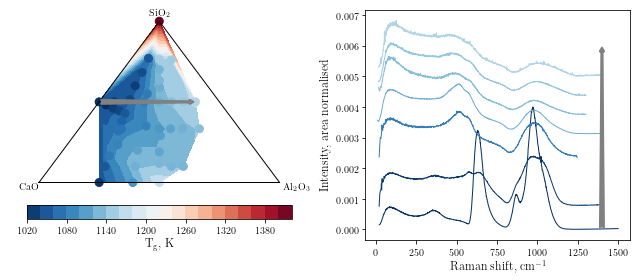

In [422]:
plt.figure(figsize=(9,4))

trig_color_plot = CA_dataset.loc[:,"Tg_K"].values

# norm is a class which, when called, can normalize data into the
# [0.0, 1.0] interval.
norm = matplotlib.colors.Normalize(
    vmin=np.min(trig_color_plot),
    vmax=np.max(trig_color_plot))

# choose a colormap
c_m = matplotlib.cm.RdBu_r

# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm)
s_m.set_array([])

ax= plt.subplot(1,2,1)
tc1 = plt.tricontourf(cart_[:,0], 
                cart_[:,1], 
                CA_dataset.loc[:,"Tg_K"], 
                levels=20, cmap="RdBu_r")

ax.scatter(cart_[:,0],cart_[:,1],c=CA_dataset.loc[:,"Tg_K"].values, cmap="RdBu_r")
ax.plot([0,1,2,0],[0,1,0,0],"k-")

plt.annotate(r"SiO$_2$", xy = (1,1.03),xycoords="data",ha="center")
plt.annotate(r"Al$_2$O$_3$", xy = (2.03,0.),xycoords="data",ha="left",va="top")
plt.annotate(r"CaO", xy = (0,0.0),xycoords="data",ha="right",va="top")

ax.axis("off")

#ax.axis('off') 
cbar_0 = plt.colorbar(orientation="horizontal",pad=0.05)
cbar_0.set_label(r"T$\textsubscript{g}$, K")

# Arrow
ax.annotate("", xy=arrow_coords[1], xytext=arrow_coords[0],
            arrowprops=dict(arrowstyle="fancy",color="0.5",lw=2.0))


plt.tight_layout()

ax2 = plt.subplot(1,2,2)

name_sp_plot = CA_dataset.loc[CA_dataset.sio2.values==0.5,"spectre"]
x_sp_plot = x[:,CA_dataset.sio2.values==0.5]
y_sp_plot = spectra[:,CA_dataset.sio2.values==0.5]
shift_sp_plot = CA_dataset.loc[CA_dataset.sio2.values==0.5,"al2o3"].values
line_color_plot = CA_dataset.loc[CA_dataset.sio2.values==0.5,"Tg_K"]

# plotting spectra
# calling the ScalarMappable that was initialised with c_m and norm
for i in range(y_sp_plot.shape[1]):
    plt.plot(x_sp_plot[:,i],
             y_sp_plot[:,i]+shift_sp_plot[i]/80,
             color=s_m.to_rgba(line_color_plot.values[i]))

# Arrow
plt.annotate("", xy=(1400,0.006), xytext=(1400,0.0), xycoords="data",
             arrowprops=dict(arrowstyle="fancy",color="0.5",lw=2.0))


# Labels
plt.xlabel("Raman shift, cm$^{-1}$")
plt.ylabel("Intensity, area normalised")

plt.tight_layout()

plt.savefig("Fig5.pdf")

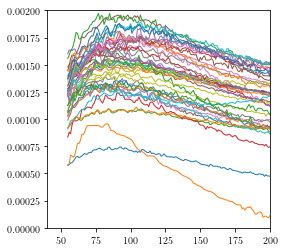

In [458]:
plt.plot(x_array,
         spectra_array)

plt.xlim(40,200)
plt.ylim(0,0.002)
plt.show()

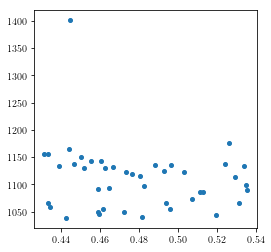

In [493]:
bary_TOT = rp.centroid(x_array[(300<x_array[:,0])&(x_array[:,0]<600),:],spectra_array[(300<x_array[:,0])&(x_array[:,0]<600),:])
bary_TO = rp.centroid(x_array[(800<x_array[:,0])&(x_array[:,0]<1250),:],spectra_array[(800<x_array[:,0])&(x_array[:,0]<1250),:])

A_TOT = np.max(spectra_array[(300<x_array[:,0])&(x_array[:,0]<750),:],axis=0)
A_TO = np.max(spectra_array[(800<x_array[:,0])&(x_array[:,0]<1250),:],axis=0)
plt.plot(bary_TOT/bary_TO,CA_dataset.loc[:,"Tg_K"],".")
plt.show()

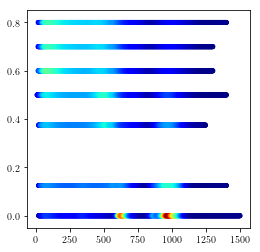

In [433]:
fake_y = np.ones(x_sp_plot.shape) * CA_dataset.loc[CA_dataset.sio2.values==0.5,"al2o3"].values/0.50
plt.scatter(x_sp_plot,fake_y,c=y_sp_plot,marker='.',cmap="jet")

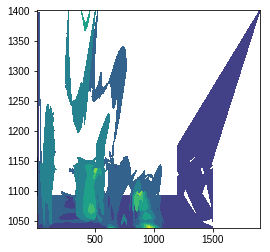

In [257]:
y = np.zeros(x.shape)
for i in range(y.shape[1]):
    #y[:,i] = IFS_Ca.fillna(value=0).ifsmr.values[i]/IFS_Ca.fillna(value=0).ifstr.values[i]
    y[:,i] = CA_dataset.Tg_K.values[i]
    
plt.contourf(x,y,spectra)

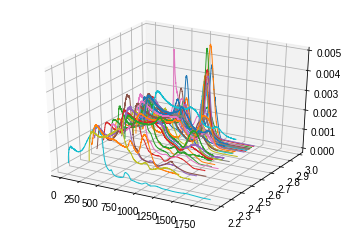

In [214]:
from matplotlib.collections import LineCollection

# Reformat it to what `LineCollection` expects:
lines = [zip(x, y) for x, y in lines]

z = np.array([0.1, 9.4, 3.8, 2.0])

fig, ax = plt.subplots()
lines = LineCollection(lines, array=z, cmap=plt.cm.rainbow, linewidths=5)
ax.add_collection(lines)
fig.colorbar(lines)

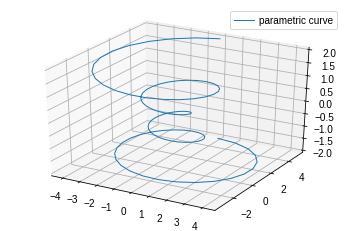

In [187]:
fig = plt.figure()
ax = fig.gca(projection='3d')
theta = np.linspace(-4 * np.pi, 4 * np.pi, 100)
z = np.linspace(-2, 2, 100)
r = z**2 + 1
x = r * np.sin(theta)
y = r * np.cos(theta)
ax.plot(x, y, z, label='parametric curve')
ax.legend()

In [173]:
y.shape

(100,)